In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy, pylab
import matplotlib.pyplot as plt
import scipy.io.wavfile
import math

Using the `stft` and `istft` functions from [Steve Tjoa](http://stackoverflow.com/questions/2459295/invertible-stft-and-istft-in-python). Modified it to use rfft so we only have the positive part, and get the DFT by taking the absolute value, a la [jojek](http://dsp.stackexchange.com/questions/20500/negative-values-of-the-fft). Additionally, we want to zero-pad to improve our resolution (although that doesn't do as much as one would hope). For more on that, read [hotpaw2's answer](http://dsp.stackexchange.com/questions/741/why-should-i-zero-pad-a-signal-before-taking-the-fourier-transform) on StackOverflow.

In [2]:
def stft(x, fs, framesz, hop, pad=0):
    framesamp = int(framesz*fs)
    hopsamp = int(hop*fs)
    w = scipy.hanning(framesamp)
    X = np.abs(scipy.array([np.fft.rfft(np.lib.pad(w*x[i:i+framesamp], (framesamp*pad,), 'constant', constant_values=(0,)))
                     for i in range(0, len(x)-framesamp, hopsamp)]))/framesamp*2
    return X

I'm creating a `TrainingData` type to store the audio and onset/offset data, as well as handle the preprocessing of the audio and the memory management. I'll likely have to create some MAPSReader as well to construct paths and load the MAPS data properly.

In [3]:
class TrainingData:
    def __init__(self, file_name):
        # read in the audio of the file
        self.rate, self.x = scipy.io.wavfile.read(file_name+'.wav')
        self.duration = len(self.x) / self.rate
        # read in the training data
        self.notes = pd.read_csv(file_name+'.txt', sep='\t')
        self.notes.columns = ['onset_time', 'offset_time', 'midi_pitch']
        # some key constants
        self.window_size = 0.050
        self.hop_size = 0.025
        self.pad = 5

Here's the function to preprocess the MAPS data. It windows and performs the stft of the audio data, convolves the data with a filter bank, and then lines up each window with the notes occuring at that time.

The shape that stft returns is [windows, fourier values]. In the below code, framesz is the width of the frame in seconds (in our case, we are using 50ms) and hop is the stride of the frames (because we want 50% overlap, we're using a hop of 25ms).

In [4]:
def transform(self):
    self.X = stft(self.x[:, 0], self.rate, self.window_size, hop=self.hop_size, pad=self.pad)
    self.F = np.fft.rfftfreq(int(self.rate*self.window_size*(2*self.pad+1)), 1.0/self.rate)
    
    # clean up the variables we will no longer be using
    del self.x

TrainingData.transform = transform

In [5]:
def preprocess(self, filterbank):
    count = np.shape(self.X)[0]
    self.data = np.zeros((count, filterbank.width))
    for i in range(count):
        self.data[i, :] = filterbank.apply_filterbank(self.X[i, :])
    
TrainingData.preprocess = preprocess

In [6]:
audio = TrainingData('../data/MUS/MAPS_MUS-alb_esp2_AkPnStgb')
# audio = TrainingData('../data/MUS/MAPS_MUS-bk_xmas2_AkPnStgb')
audio.transform()

### Computing Our Filters

The equation we'll use for each semitone note is $ f_n = f_0 * a^n $ where $ a = 2^{1/12} $ and $ n $ is the number of semitones away from the fundamental frequency we are. We'll use $ f_0 $ = 440Hz for the central A. A lot of the preprocessing I'm doing (as in, almost all of it) is coming from [this paper](http://www.music-ir.org/evaluation/mirex-results/articles/onset/pertusa.pdf).


In [7]:
def compute_freq(f0, count):
    return f0 * math.pow(math.pow(2, 1.0/12.0), count)

class FilterBank:
    def __init__(self, fftfreqs):
        self.bands = []
        self.freqs = fftfreqs
        self.diff = self.freqs[1]-self.freqs[0]
        self.offset = self.freqs[0]/self.diff
    
    def discretize(self, value):
        return int(round(value/self.diff)-self.offset)

    def band(self, low, center, high):
        l, c, h = self.discretize(low), self.discretize(center), self.discretize(high)
        self.bands.append(Band(l, c, h))
    
    def construct_bands(self, f0, n_below, n_above):
        for i in range(1, n_below+1)[::-1]:
            self.band(compute_freq(f0, -i-1), compute_freq(f0, -i), compute_freq(f0, -i+1))
        for i in range(n_above+1):
            self.band(compute_freq(f0, i-1), compute_freq(f0, i), compute_freq(f0, i+1))
        self.width = n_below + n_above + 1
    
    def apply_filterbank(self, freqs):
        values = np.zeros(len(self.bands))
        for i, band in enumerate(self.bands):
            values[i-11] = band.values.dot(freqs[band.low:band.high+1]) / band.total
        return values

class Band:
    def __init__(self, low, center, high):
        self.low, self.center, self.high = low, center, high
        self.construct()
        
    def construct(self):
        f, s = self.center-self.low, self.high-self.center
        self.values = np.zeros(self.high-self.low+1)
        for i in range(f):
            self.values[i] = float(i)/f
        for i in range(s+1):
            self.values[f+i] = float(s-i)/s
        self.total = np.sum(self.values)

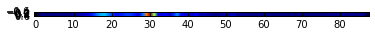

In [8]:
f = FilterBank(audio.F.flatten())
num_lower_notes = 48
num_upper_notes = 39
# num_lower_notes = 20
# num_upper_notes = 20
f.construct_bands(440.0, num_lower_notes, num_upper_notes)

tones = f.apply_filterbank(audio.X[20, :])
# np.shape(tones)

plt.imshow([tones])
plt.show()

We can now preprocess the data using our `FilterBank`. The current `FilterBank` has 41 notes centered around A at 440Hz. When we call `preprocess` on our TrainingData instance, it applies the filterbank over the length of the musical piece.

In [9]:
audio.preprocess(f)
print np.shape(audio.data)

(5099, 88)


From here, we can see what the output looks like. Pretty promising, no?

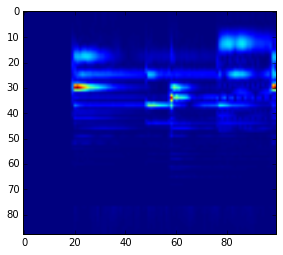

In [10]:
plt.imshow(audio.data[0:100, :].T)
plt.show()

### Loading the Label Data

In addition to the actual audio data, we need the align the note labels to the music, in a vector format. Since we're using [midi pitches](https://www.finalemusic.com/UserManuals/Finale2012Mac/Content/Finale/MIDI_Note_to_Pitch_Table.htm), we'll have a length 88 vector with several-hot notation.

For instnace, if our vector was length 5, and we had notes 2 and 3 on at a specific time, our resulting vector would be: 
```[0, 0, 1, 1, 0]``` (assuming 0-indexed). Note that MIDI pitches are **21-indexed**, so we have to account for the offset. The pitches in the training data thus range from 21 to 108.

In [11]:
def label(self):
    count = np.shape(self.X)[0]
    self.Y = np.zeros((count, 88))
    factor = (self.window_size - self.hop_size)
    for i, row in self.notes.iterrows():
        onset_index = int(math.floor(row.onset_time / factor + self.hop_size))
        offset_index = int(round(row.offset_time / factor + self.hop_size))
        self.Y[onset_index:offset_index, int(row.midi_pitch-21)] = 1.0

TrainingData.label = label

audio.label()

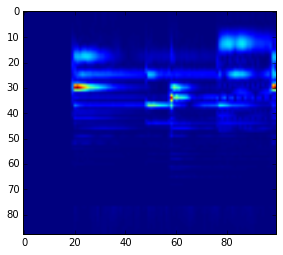

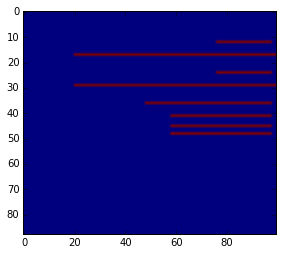

In [12]:
plt.figure()
plt.imshow(audio.data[0:100, :].T)
plt.figure()
plt.imshow(audio.Y[0:100, :].T)
plt.show()

#### Bootstrapping the Filterbank

Using information from [this post](http://electronics.stackexchange.com/questions/12407/what-is-the-relation-between-fft-length-and-frequency-resolution) I compute the resolution of the fourier transform and create a filterbank from that, rather than the audio data.

In [14]:
bins = (44100 * 0.05 * (2 * 5 + 1)) / 2
resolution = 22050 / bins
frequencies = np.array([resolution*i for i in range(int(round(bins)))])

for i, b in enumerate(audio.F):
    if b != frequencies[i]:
        print "Found one at:", i
        break